# Улучшение эмбеддингов с помощью смещенных случайных блужданий в Node2Vec

/Users/artemgruzdev/anaconda3/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


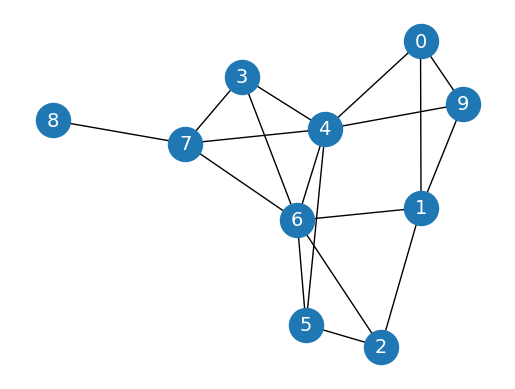

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# создаем граф
G = nx.erdos_renyi_graph(10, 0.3, seed=1, directed=False)

# визуализируем граф
plt.figure()
plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 node_size=600,
                 cmap='coolwarm',
                 font_size=14,
                 font_color='white'
                 )

In [2]:
import numpy as np

def next_node(previous, current, p, q):
    # создаем пустой список для значений alpha
    alphas = []

    # получаем список узлов, являющихся 
    # соседями текущего узла
    neighbors = list(G.neighbors(current))
    
    # вычисляем соответствующее значение alpha для каждого соседа
    for neighbor in neighbors:
        # расстояние = 0: вероятность возврата к предыдущему узлу
        if neighbor == previous:
            alpha = 1/p
        # расстояние = 1: вероятность посещения локального узла
        elif G.has_edge(neighbor, previous):
            alpha = 1
        # расстояние = 2: вероятность исследовать неизвестный узел
        else:
            alpha = 1/q
        alphas.append(alpha)

    # нормализуем значения alpha, чтобы получить вероятности перехода
    probs = [alpha / sum(alphas) for alpha in alphas]
    
    # случайно выбираем новый узел на основе вероятностей перехода
    next = np.random.choice(neighbors, size=1, p=probs)[0]
    return next

In [3]:
def random_walk(start, length, p, q):
    walk = [start]
    
    for i in range(length):
        current = walk[-1]
        previous = walk[-2] if len(walk) > 1 else None
        next = next_node(previous, current, p, q)
        walk.append(next)
    
    return walk

In [4]:
np.random.seed(0)

random_walk(0, 8, p=1, q=1)

[0, 4, 7, 6, 4, 5, 4, 5, 6]

In [5]:
np.random.seed(0)

random_walk(0, 8, p=1, q=10)

[0, 4, 9, 4, 7, 4, 6, 4, 7]

In [6]:
np.random.seed(0)

random_walk(0, 8, p=10, q=1)

[0, 4, 7, 6, 3, 4, 7, 6, 5]

In [7]:
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# загружаем набор данных
G = nx.karate_club_graph()

# создаем метки (Mr. Hi = 0, Officer = 1)
labels = []
for node in G.nodes:
    label = G.nodes[node]['club']
    labels.append(1 if label == 'Officer' else 0)

# создаем список случайных блужданий
walks = []
for node in G.nodes:
    for _ in range(80):
        walks.append(random_walk(node, 10, 3, 2))

# создаем и обучаем Word2Vec для DeepWalk
node2vec = Word2Vec(walks,
                hs=1, # иерархический softmax
                sg=1, # skip-gram
                vector_size=100,
                window=10,
                workers=2,
                min_count=1,
                seed=0)

node2vec.train(walks, 
               total_examples=node2vec.corpus_count,
               epochs=30, 
               report_delay=1)

# создаем маски для обучения и тестирования модели
train_mask = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
test_mask = [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 
             23, 25, 26, 27, 28, 29, 30, 31, 32, 33]
labels = np.array(labels)

# обучаем классификатор на данных, полученных с помощью Node2Vec
clf = RandomForestClassifier(random_state=0)
clf.fit(node2vec.wv[train_mask], labels[train_mask])

# оцениваем качество модели
y_pred = clf.predict(node2vec.wv[test_mask])
acc = accuracy_score(y_pred, labels[test_mask])
print(f'Правильность на данных Node2Vec = {acc*100:.2f}%')

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Правильность на данных Node2Vec = 90.91%


In [8]:
import pandas as pd

# создаем списки для хранения комбинаций p и q,
# средних значений правильности, стандартных
# отклонений правильности
combinations = []
mean_acc_scores = []
std_acc_scores = []

for p in [1, 2, 3, 4, 5, 6, 7]:
    for q in [1, 2, 3, 4, 5, 6, 7]:
        
        # записываем комбинации p и q
        combinations.append(f"p={p} и q={q}")
        
        # создаем пустой лист для хранения значений правильности
        acc_lst = []
        
        # 10 раз повторяем следующие шаги
        for _ in range(10):
            # создаем список случайных блужданий
            walks = []
            for node in G.nodes:
                for _ in range(80):
                    walks.append(random_walk(node, 10, p, q))
                
            # создаем и обучаем Word2Vec для DeepWalk
            node2vec = Word2Vec(walks,
                                hs=1, # иерархический softmax
                                sg=1, # skip-gram
                                vector_size=100,
                                window=10,
                                workers=2,
                                min_count=1,
                                seed=0)

            node2vec.train(walks, 
                           total_examples=node2vec.corpus_count,
                           epochs=30, 
                           report_delay=1)
    
            # обучаем классификатор на данных, полученных с помощью Node2Vec
            clf = RandomForestClassifier(random_state=0)
            clf.fit(node2vec.wv[train_mask], labels[train_mask])

            # оцениваем качество модели
            y_pred = clf.predict(node2vec.wv[test_mask])
            acc = accuracy_score(y_pred, labels[test_mask])
            # добавляем значение правильности в список
            acc_lst.append(acc)    
            
        # расчет среднего значения правильности
        acc_mean = np.mean(acc_lst)
        # расчет стандартного отклонения правильности
        acc_std = np.std(acc_lst)  
        
        # добавляем средние значения и стандартные отклонения
        # в соответствующие списки
        mean_acc_scores.append(acc_mean * 100)
        std_acc_scores.append(acc_std * 100)

# вычисляем средние значения правильности со штрафом
penalty_mean_acc_scores = np.subtract(
    np.array(mean_acc_scores), np.array(std_acc_scores)
)

# создаем датафрейм
df = pd.DataFrame({"Правильность mean": mean_acc_scores,
                   "Правильность std": std_acc_scores, 
                   "Правильность со штрафом": penalty_mean_acc_scores},
                 index=combinations)

# сортируем по усредненной правильности со штрафом
df = df.sort_values(by='Правильность со штрафом', ascending=False)
df

,Правильность mean,Правильность std,Правильность со штрафом
p=5 и q=6,98.181818,2.226809,95.955009
p=5 и q=3,97.727273,2.272727,95.454545
p=6 и q=3,97.727273,2.272727,95.454545
p=2 и q=5,96.818182,2.082989,94.735193
p=4 и q=3,97.272727,3.015113,94.257614
p=6 и q=2,96.818182,2.910511,93.907671
p=5 и q=2,96.363636,2.727273,93.636364
p=7 и q=1,96.363636,2.727273,93.636364
p=2 и q=7,96.363636,2.727273,93.636364
p=7 и q=5,95.454545,2.032789,93.421756


In [9]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'
with urlopen(url) as zurl:
    with ZipFile(BytesIO(zurl.read())) as zfile:
        zfile.extractall('.')

In [10]:
ratings = pd.read_csv('ml-100k/u.data', sep='\t', 
                      names=['user_id', 'movie_id', 
                             'rating', 'unix_timestamp'])
ratings

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [11]:
movies = pd.read_csv('ml-100k/u.item', sep='|', 
                     usecols=range(2), 
                     names=['movie_id', 'title'], 
                     encoding='latin-1')
movies

,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
...,...,...
1677,1678,Mat' i syn (1997)
1678,1679,B. Monkey (1998)
1679,1680,Sliding Doors (1998)
1680,1681,You So Crazy (1994)


In [12]:
# оставляем фильмы только с высокими рейтингами
ratings = ratings[ratings.rating >= 4]
ratings

,user_id,movie_id,rating,unix_timestamp
5,298,474,4,884182806
7,253,465,5,891628467
11,286,1014,5,879781125
12,200,222,5,876042340
16,122,387,5,879270459
...,...,...,...,...
99988,421,498,4,892241344
99989,495,1091,4,888637503
99990,806,421,4,882388897
99991,676,538,4,892685437


In [13]:
from collections import defaultdict
pairs = defaultdict(int)

# по каждому пользователю в списке пользователей
for group in ratings.groupby("user_id"):
    # список идентификаторов фильмов, которые 
    # понравились текущему пользователю
    user_movies = list(group[1]["movie_id"])

    # подсчитываем, сколько раз два фильма оказались
    # в одном списке
    for i in range(len(user_movies)):
        for j in range(i+1, len(user_movies)):
            pairs[(user_movies[i], user_movies[j])] += 1

In [14]:
# создаем граф
G = nx.Graph()

# пытаемся создать ребро между двумя фильмами,
# которые оба понравились пользователю
for pair in pairs:
    movie1, movie2 = pair
    score = pairs[pair]

    # ребро создаем только тогда, когда оценка
    # является достаточно высокой
    if score >= 20:
        G.add_edge(movie1, movie2, weight=score)

print("Общее количество узлов в графе:", G.number_of_nodes())
print("Общее количество ребер в графе:", G.number_of_edges())

Общее количество узлов в графе: 410
Общее количество ребер в графе: 14936


In [15]:
from node2vec import Node2Vec

node2vec = Node2Vec(G, dimensions=64, walk_length=20, 
                    num_walks=200, p=2, q=1, workers=1)

model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/410 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████| 200/200 [00:38<00:00,  5.24it/s]


In [16]:
def recommend(movie):
    movie_id = str(movies[movies.title == movie].movie_id.values[0])
    for id in model.wv.most_similar(movie_id)[:5]:
        title = movies[movies.movie_id == int(id[0])].title.values[0]
        print(f'{title}: {id[1]:.2f}')

recommend('Star Wars (1977)')

Raiders of the Lost Ark (1981): 0.60
Return of the Jedi (1983): 0.55
Toy Story (1995): 0.51
Silence of the Lambs, The (1991): 0.48
Empire Strikes Back, The (1980): 0.46
